### Fuzzy matching bei chunk ranking -> wurde geändert zu Cosine similarity (semantisch und nichtmehr stringbasiert)

In [ ]:
# 1) Load all evaluation questions
with open("question-sets/q_v2.json", "r", encoding="utf-8") as f:
    all_questions = json.load(f)
print(f"Total questions: {len(all_questions)}")

# 2) Split and filter context into chunks
context_chunks = context.split("\n\n")
print(f"Total chunks: {len(context_chunks)}")

min_words = 20
filtered_chunks = [ch for ch in context_chunks if len(ch.split()) >= min_words]
print(f"Chunks ≥ {min_words} words: {len(filtered_chunks)}")

# 3) Compute aggregate relevance score per chunk
chunk_scores = []
for idx, chunk in enumerate(filtered_chunks):
    # Sum relevance scores across all questions
    total_score = 0
    for q in all_questions:

        # vorversuch: String-basiertes Chunk-ranking: total_score += fuzz.partial_ratio(q["question"].lower(), chunk.lower())
    
    # Optionally, average = total_score / len(all_questions)
    #chunk_scores.append((idx, total_score, chunk))

# 4) Sort chunks by descending total_score
chunk_scores.sort(key=lambda x: x[1], reverse=True)

# 5) Select top_k most relevant chunks overall
top_k = 5
top_chunks = chunk_scores[:top_k]
print(f"Selected top {top_k} chunks based on aggregate relevance:")
for rank, (idx, score, _) in enumerate(top_chunks, 1):
    print(f"  {rank}. Chunk #{idx} — Total Score: {score}")

# 6) Build the reduced context and save
reduced_context = "\n\n".join(chunk for (_, _, chunk) in top_chunks)
print(f"\nReduced context char length: {len(reduced_context)}")

with open("reduced_context.txt", "w", encoding="utf-8") as f:
    f.write(reduced_context)

print(f"Context length reduced by {(1 - len(reduced_context) / len(context)) * 100:.2f}%")
print("Reduced context saved to 'reduced_context.txt'")


### Ursprüngliche eval. methode war stringbasiert/fuzzy matching -> wurde geändert zu semantischer methode (dauert etwas länger aber deutlich sinnvoller, kein manueller Zusatzaufwand, skalierbar)

In [ ]:
from thefuzz import fuzz

def evaluate_qa(data: list,
                      context: str,
                      nlp_callable,
                      threshold: int) -> float:
    correct = 0  # initialize correct count
    total = len(data)  # total number of questions

    for item in data:
        question = item["question"] 
        expected = item["answer"]
        QA_input = {"question": question, "context": context}  # prepare model input

        result = nlp_callable(QA_input)  # run QA pipeline
        pred = result["answer"]  # extract predicted answer
        sim = fuzz.ratio(pred.lower(), expected.lower())  # compute similarity

        status = "✅" if sim >= threshold else "❌"  # check against threshold
        print(f"{status} Question: {question}")
        print(f"   Expected: {expected}         Received: {pred}\n")
        #print(f"   Similarity: {sim}%\n")

        if sim >= threshold:
            correct += 1  # increment if prediction is close enough

    accuracy = (correct / total) * 100 if total else 0  # calculate accuracy
    print(f"\n✅ Accuracy: {accuracy:.2f}% ({correct}/{total} correct)")
    return accuracy  # return the accuracy percentage


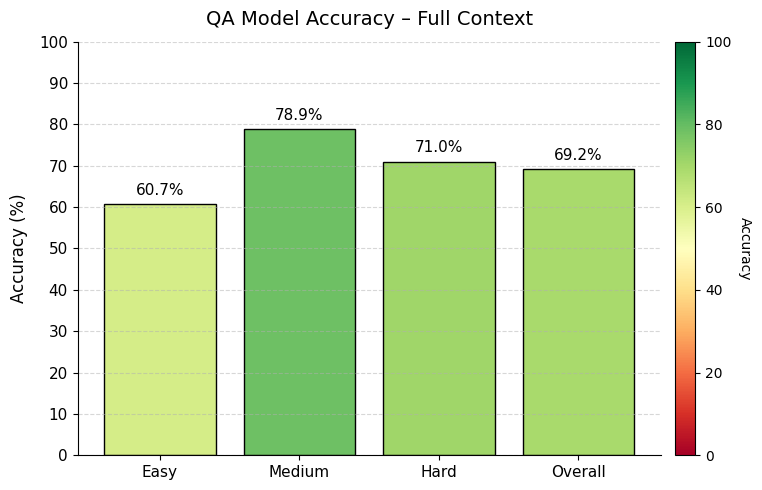

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
categories = ['Easy', 'Medium', 'Hard', 'Overall']
accuracies = np.array([60.7, 78.9, 71.0, 69.2])  # Prozentwerte

# Normierung auf [0, 1] für Colormap
normed = accuracies / 100.0

# Colormap: Rot → Gelb → Grün
cmap = plt.get_cmap('RdYlGn')
colors = cmap(normed)

# Figure und Achsen
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(categories, accuracies, color=colors, edgecolor='black', linewidth=1)

# Achsentitel und Diagrammtitel
ax.set_ylabel('Accuracy (%)', fontsize=12, labelpad=8)
ax.set_ylim(0, 100)
ax.set_title('QA Model Accuracy – Full Context', fontsize=14, pad=12)

# Gitternetzlinie nur horizontal, dezent
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Werte über den Balken anzeigen
for bar, value in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.5,
        f"{value:.1f}%",
        ha='center',
        va='bottom',
        fontsize=11
    )

# Achsenanpassungen für Eleganz
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=11)
ax.set_yticks(range(0, 101, 10))
ax.tick_params(axis='y', labelsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Colorbar hinzufügen als Legende
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


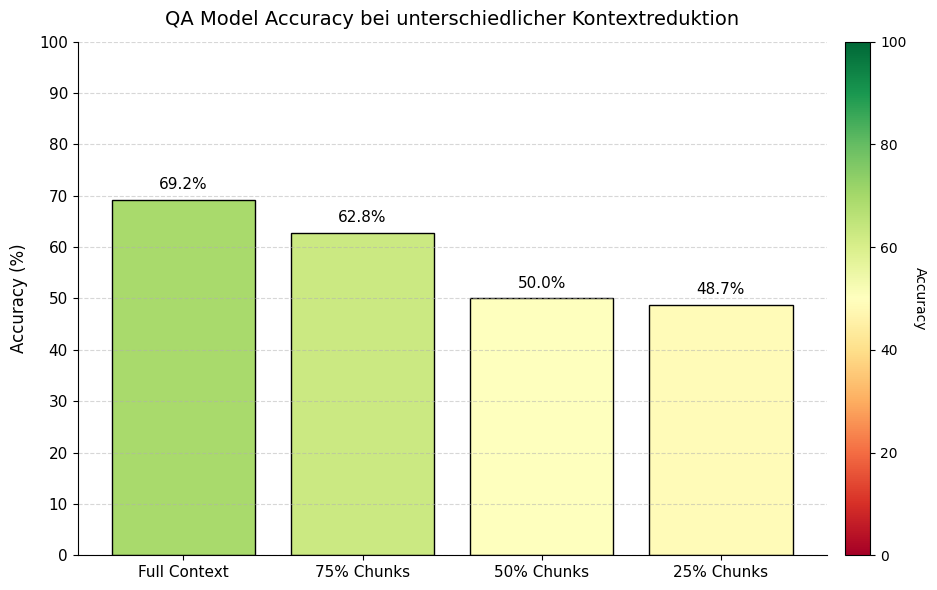

In [8]:
# Gegebene Daten für die Experimente
labels = ['Full Context', '75% Chunks', '50% Chunks', '25% Chunks']
accuracies = np.array([69.2, 62.8, 50.0, 48.7])  # Prozentuale Genauigkeit
reduction = np.array([0.0, 23.32, 45.91, 68.00])  # Prozentuale Reduktion des Kontextes

# Normierung für Colormap (Accuracy 0 → rot, 100 → grün)
normed = accuracies / 100.0
cmap = plt.get_cmap('RdYlGn')
colors = cmap(normed)

# Erste Figur: Bar-Chart der Accuracy, farbkodiert nach Wert
fig1, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(labels, accuracies, color=colors, edgecolor='black', linewidth=1)

# Achsentitel und Diagrammtitel
ax1.set_ylabel('Accuracy (%)', fontsize=12, labelpad=8)
ax1.set_ylim(0, 100)
ax1.set_title('QA Model Accuracy bei unterschiedlicher Kontextreduktion', fontsize=14, pad=12)

# Gitternetzlinie nur horizontal, dezent
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Werte über den Balken anzeigen
for bar, value in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.5,
        f"{value:.1f}%",
        ha='center',
        va='bottom',
        fontsize=11
    )

# Achsenanpassungen für Eleganz
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, fontsize=11)
ax1.set_yticks(range(0, 101, 10))
ax1.tick_params(axis='y', labelsize=11)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Colorbar hinzufügen als Legende für Accuracy
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = fig1.colorbar(sm, ax=ax1, pad=0.02)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()



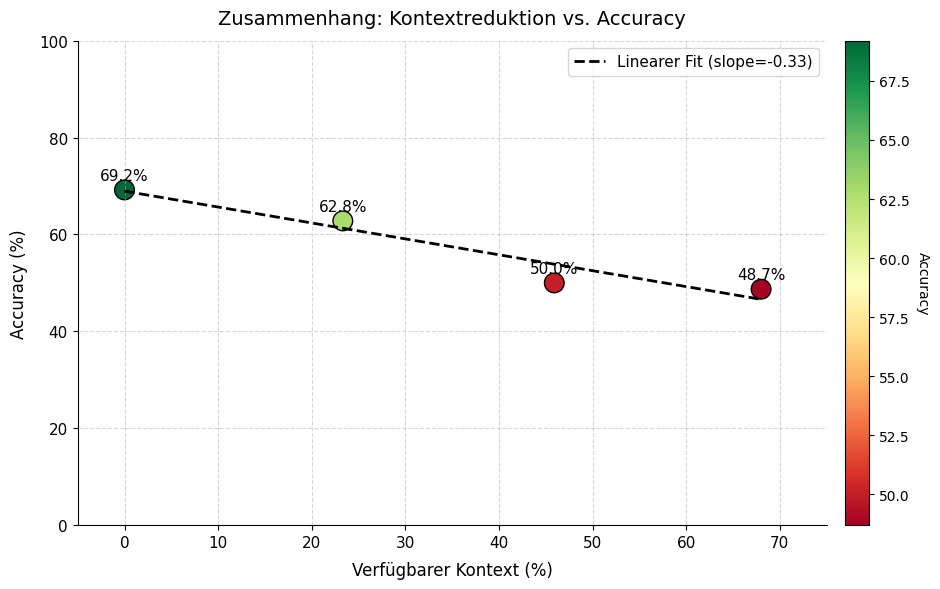

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Gegebene Daten für die Experimente
reduction = np.array([0.0, 23.32, 45.91, 68.00])  # Prozentuale Reduktion des Kontextes
accuracies = np.array([69.2, 62.8, 50.0, 48.7])    # Prozentuale Genauigkeit

# Normierung für Colormap (Accuracy 0 → rot, 100 → grün)
normed = accuracies / 100.0
cmap = plt.get_cmap('RdYlGn')

# Figure und Achsen erstellen
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter-Plot der Datenpunkte, farbkodiert nach Accuracy
scatter = ax.scatter(reduction, accuracies, c=accuracies, cmap='RdYlGn', s=200, edgecolors='black')

# Eine lineare Regression (Best-Fit-Linie) durch die Punkte berechnen
coeffs = np.polyfit(reduction, accuracies, 1)  # Grad 1 = lineare Regression
slope, intercept = coeffs
x_line = np.linspace(min(reduction), max(reduction), 100)
y_line = slope * x_line + intercept

# Regressionslinie in das Diagramm zeichnen
ax.plot(x_line, y_line, color='black', linestyle='--', linewidth=2,
        label=f'Linearer Fit (slope={slope:.2f})')

# Beschriftungen für die Punkte
for x, y in zip(reduction, accuracies):
    ax.text(x, y + 1.5, f"{y:.1f}%", ha='center', va='bottom', fontsize=11)

# Achsentitel und Diagrammtitel
ax.set_xlabel('Verfügbarer Kontext (%)', fontsize=12, labelpad=8)
ax.set_ylabel('Accuracy (%)', fontsize=12, labelpad=8)
ax.set_xlim(-5, 75)
ax.set_ylim(0, 100)
ax.set_title('Zusammenhang: Kontextreduktion vs. Accuracy', fontsize=14, pad=12)

# Gitternetzlinien
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Achsenanpassungen für Eleganz
ax.tick_params(axis='both', labelsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Colorbar für Scatter-Plot
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

# Legende für die Regressionslinie
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


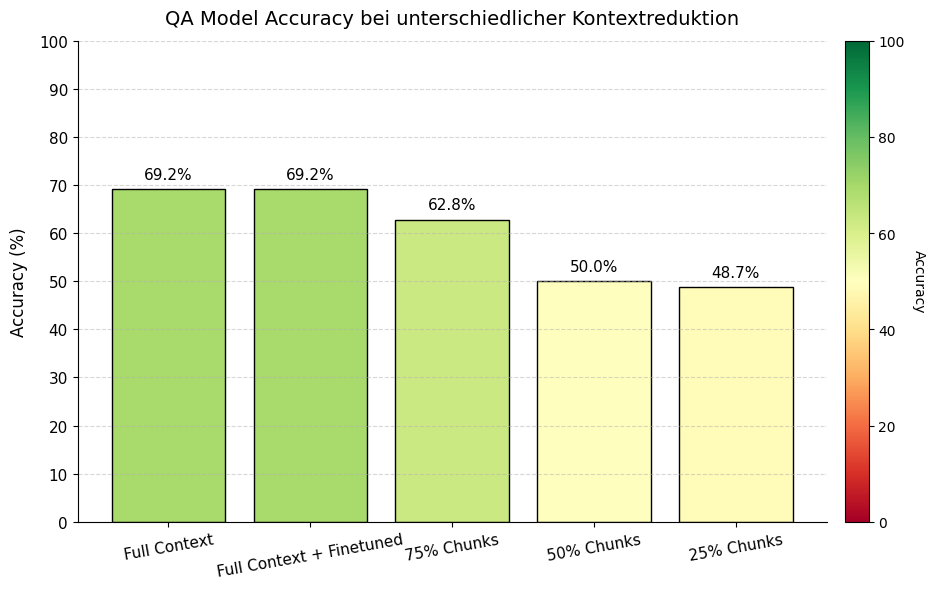

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Neue Labels und Daten mit zusätzlichem Balken für "Full Context + Finetuned"
labels = ['Full Context', 'Full Context + Finetuned', '75% Chunks', '50% Chunks', '25% Chunks']
accuracies = np.array([69.2, 69.2, 62.8, 50.0, 48.7])  # Prozentuale Genauigkeit
reduction = np.array([0.0, 0.0, 23.32, 45.91, 68.00])  # Prozentuale Reduktion des Kontextes

# Normierung für Colormap (Accuracy 0 → rot, 100 → grün)
normed = accuracies / 100.0
cmap = plt.get_cmap('RdYlGn')
colors = cmap(normed)

# Erste Figur: Bar-Chart der Accuracy, farbkodiert nach Wert
fig1, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(labels, accuracies, color=colors, edgecolor='black', linewidth=1)

# Achsentitel und Diagrammtitel
ax1.set_ylabel('Accuracy (%)', fontsize=12, labelpad=8)
ax1.set_ylim(0, 100)
ax1.set_title('QA Model Accuracy bei unterschiedlicher Kontextreduktion', fontsize=14, pad=12)

# Gitternetzlinie nur horizontal, dezent
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Werte über den Balken anzeigen
for bar, value in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.5,
        f"{value:.1f}%",
        ha='center',
        va='bottom',
        fontsize=11
    )

# Achsenanpassungen für Eleganz
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, fontsize=11, rotation=10)
ax1.set_yticks(range(0, 101, 10))
ax1.tick_params(axis='y', labelsize=11)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Colorbar hinzufügen als Legende für Accuracy
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = fig1.colorbar(sm, ax=ax1, pad=0.02)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()
